# Run Code

In [1]:
%matplotlib inline

import glob
import matplotlib.pyplot as plt
import nilearn.image, nilearn.masking, nilearn.plotting
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

/Users/eyshin/.pyenv/versions/eyspy3.6/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/Users/eyshin/.pyenv/versions/eyspy3.6/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/eyshin/.pyenv/versions/eyspy3.6/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: Fut

In [2]:
data_dir = '/Volumes/clmnlab/GA/MVPA/LSS_pb02_MO_short_duration/data/'

In [17]:
roi_dir = '/Volumes/clmnlab/GA/fmri_data/glm_results/localizer/'

roi_imgs = [nilearn.image.load_img(roi_dir + 'n200_c1-1_L_M1_mask.nii'), 
            nilearn.image.load_img(roi_dir + 'n200_c1-2_L_S1_mask.nii')]

roi_names = ['M1', 'S1']

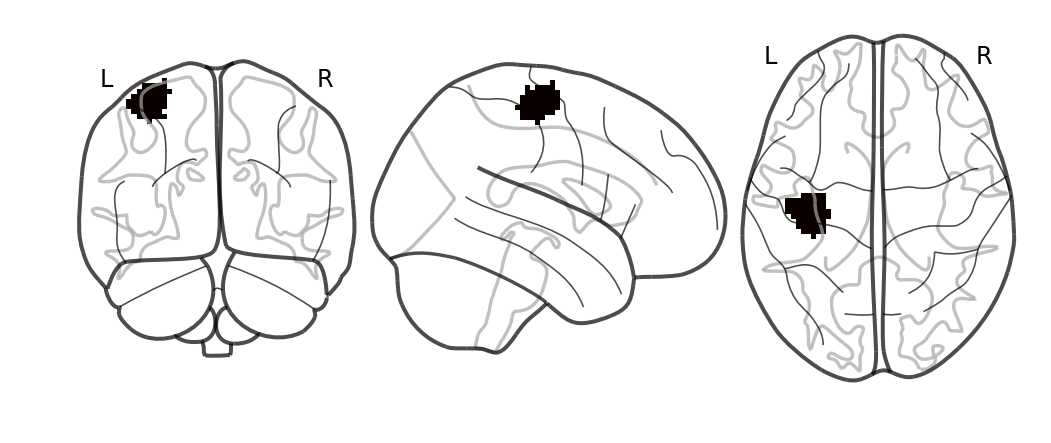

In [28]:
nilearn.plotting.plot_glass_brain(roi_imgs[0])

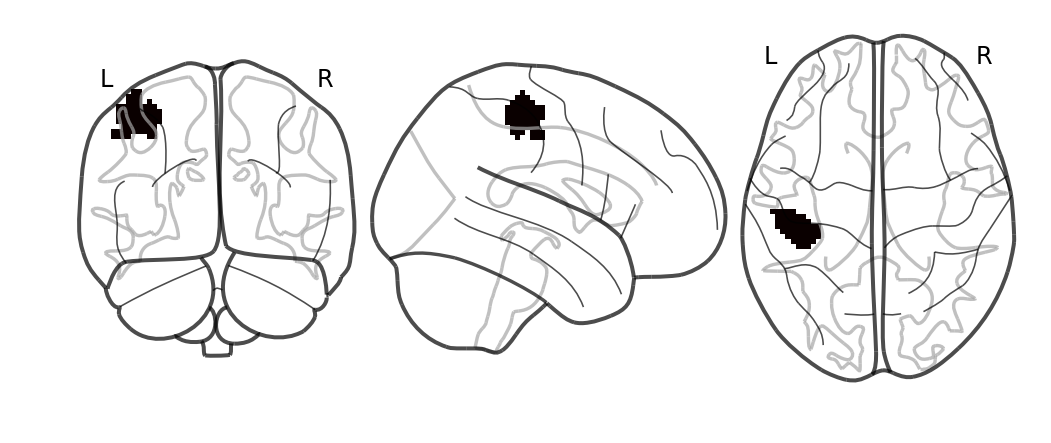

In [29]:
nilearn.plotting.plot_glass_brain(roi_imgs[1])

In [5]:
subj_list = [
    'GA01', 'GA02', 'GA05', 'GA07', 'GA08', 'GA11', 'GA12', 'GA13', 'GA14', 'GA15',
    'GA18', 'GA19', 'GA20', 'GA21', 'GA23', 'GA26', 'GA27', 'GA28', 'GA29', 'GA30',
    'GA31', 'GA32', 'GA33', 'GA34', 'GA35', 'GA36', 'GA37', 'GA38', 'GA42', 'GA44',
    'GB01', 'GB02', 'GB05', 'GB07', 'GB08', 'GB11', 'GB12', 'GB13', 'GB14', 'GB15',
    'GB18', 'GB19', 'GB20', 'GB21', 'GB23', 'GB26', 'GB27', 'GB28', 'GB29', 'GB30',
    'GB31', 'GB32', 'GB33', 'GB34', 'GB35', 'GB36', 'GB37', 'GB38', 'GB42', 'GB44'
]

In [6]:
data = {}

for subj in subj_list:
    for run in range(1, 7):
        data[subj, run] = nilearn.image.load_img(data_dir + 'betasLSS.MO.shortdur.%s.r%02d.nii.gz' % (subj, run))
    print(subj, end='\r')

In [7]:
for key, value in data.items():
    data[key] = nilearn.image.index_img(value, np.arange(1, 97))

In [8]:
target_pos = []

with open('/Volumes/clmnlab/GA/MVPA/LSS_pb02/behaviors/targetID.txt') as file:
    for line in file:
        target_pos.append(int(line.strip()))
        
target_pos = target_pos[1:97]

In [9]:
def fast_masking(img, roi):
    img_data = img.get_data()
    roi_mask = roi.get_data().astype(bool)
    
    if img_data.shape[:3] != roi_mask.shape:
        raise ValueError('different shape while masking! img=%s and roi=%s' % (img_data.shape, roi_mask.shape))
        
    return img_data[roi_mask, :].T

In [11]:
def accuracy(train_X, train_y, test_X, test_y):
    lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
    lda.fit(train_X, train_y)
    
    return np.mean(lda.predict(test_X) == test_y)

def cross_validation(datasets, target):
    train_y = target + target
    test_y = target
    
    result = []
    
    for i in range(len(datasets)):
        train_X = np.concatenate([a for j, a in enumerate(datasets) if j != i])
        test_X = datasets[i]
        
        result.append(accuracy(train_X, train_y, test_X, test_y))
        
    return np.mean(result)

In [12]:
results = {}

for subj in subj_list:
    for roi_name, roi in zip(roi_names, roi_imgs):
        
        if ('pos', 'unpracticed', subj, roi_name) in results:
            continue
        
        X = [
            fast_masking(roi=roi, img=data[subj, 1]), 
            fast_masking(roi=roi, img=data[subj, 2]), 
            fast_masking(roi=roi, img=data[subj, 3]), 
        ]
        
        results['pos', 'practiced', subj, roi_name] = cross_validation(X, target_pos)
        
        X = [
            fast_masking(roi=roi, img=data[subj, 4]), 
            fast_masking(roi=roi, img=data[subj, 5]), 
            fast_masking(roi=roi, img=data[subj, 6]), 
        ]
        
        results['pos', 'unpracticed', subj, roi_name] = cross_validation(X, target_pos)
        
        print(subj, roi_index, end='\r')

In [30]:
results['pos', 'practiced', 'GA01', 'M1'], results['pos', 'practiced', 'GA01', 'S1']

(0.3680555555555556, 0.3576388888888889)

In [13]:
len(results)

240

In [14]:
import pickle

with open('20200306_p-and-unp_e-and-l_M1-S1.pkl', 'wb') as file:
    pickle.dump(file=file, obj=results)

# Visualization

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [31]:
wit_df = pd.DataFrame(columns=['subj', 'roi_name', 'mean_acc', 'stage'])

for subj in subj_list[:30]:
    for i, roi_name in enumerate(roi_names):
        wit_df = wit_df.append({'subj': subj,
                        'roi_name': roi_name,
                        'practiced': True,
                        'mean_acc': np.mean(results['pos', 'practiced', subj, roi_name]),
                        'stage': 'Early'}, ignore_index=True)
        
        wit_df = wit_df.append({'subj': subj,
                        'roi_name': roi_name,
                        'practiced': True,
                        'mean_acc': np.mean(results['pos', 'practiced', subj.replace('A', 'B'), roi_name]),
                        'stage': 'Late'}, ignore_index=True)
        
        wit_df = wit_df.append({'subj': subj,
                        'roi_name': roi_name,
                        'practiced': False,
                        'mean_acc': np.mean(results['pos', 'unpracticed', subj, roi_name]),
                        'stage': 'Early'}, ignore_index=True)
        
        wit_df = wit_df.append({'subj': subj,
                        'roi_name': roi_name,
                        'practiced': False,
                        'mean_acc': np.mean(results['pos', 'unpracticed', subj.replace('A', 'B'), roi_name]),
                        'stage': 'Late'}, ignore_index=True)

In [32]:
import scipy.stats
import statsmodels.stats.multitest

pvals, tvals = [], []

for roi_name in roi_names:
    sub_df = wit_df[(wit_df['roi_name'] == roi_name) & (wit_df['practiced'] == True)]
    
    early_mean_accs = sub_df[sub_df['stage'] == 'Early']['mean_acc']
    late_mean_accs = sub_df[sub_df['stage'] == 'Late']['mean_acc']
    
    res = scipy.stats.ttest_rel(early_mean_accs, late_mean_accs)
    pvals.append(res.pvalue)
    tvals.append(res.statistic)

res = statsmodels.stats.multitest.fdrcorrection(pvals)

for t, p, roi_name, uncorrected_p, tval in zip(*res, roi_names, pvals, tvals):
    if uncorrected_p < 0.05:
        print('%5s'%roi_name, '%5s'%t, '%.4f'%p, '%5.4f'%tval, '%.4f'%uncorrected_p)

   M1  True 0.0004 -3.9583 0.0004
   S1  True 0.0004 -4.1126 0.0003


In [34]:
pvals, tvals = [], []

for roi_name in roi_names:
    sub_df = wit_df[(wit_df['roi_name'] == roi_name) & (wit_df['stage'] == 'Late')]
    
    early_mean_accs = sub_df[sub_df['practiced'] == True]['mean_acc']
    late_mean_accs = sub_df[sub_df['practiced'] == False]['mean_acc']
    
    res = scipy.stats.ttest_rel(early_mean_accs, late_mean_accs) 
    pvals.append(res.pvalue)
    tvals.append(res.statistic)

res = statsmodels.stats.multitest.fdrcorrection(pvals)

for t, p, roi_name, uncorrected_p, tval in zip(*res, roi_names, pvals, tvals):
    if uncorrected_p < 0.05:
        print('%5s'%roi_name, '%5s'%t, '%.4f'%p, '%5.4f'%tval, '%.4f'%uncorrected_p)

   M1  True 0.0177 2.5158 0.0177
   S1  True 0.0075 3.1542 0.0037


In [35]:
wit_df['condition'] = ['%s, Practiced = %s' % (a, bool(b)) for a, b in zip(wit_df['stage'], wit_df['practiced'])]
wit_df.head()

,subj,roi_name,mean_acc,stage,practiced,condition
0,GA01,M1,0.368056,Early,1.0,"Early, Practiced = True"
1,GA01,M1,0.326389,Late,1.0,"Late, Practiced = True"
2,GA01,M1,0.315972,Early,0.0,"Early, Practiced = False"
3,GA01,M1,0.364583,Late,0.0,"Late, Practiced = False"
4,GA01,S1,0.357639,Early,1.0,"Early, Practiced = True"


In [36]:
wit_df['practiced_str'] = ['Practiced' if a else 'Unpracticed' for a in wit_df['practiced']]

In [37]:
palette = ['#00A8AA', '#C5C7D2']

In [45]:
sns.set(style="whitegrid")

def draw_lineplot(roi_name):
    plt.figure(figsize=(5, 5))
    sub_df = wit_df[wit_df['roi_name'] == roi_name]
    sns.pointplot(x='stage', y='mean_acc', hue='practiced_str', data=sub_df, 
                  palette=palette, markers='s', scale=1, ci=68, errwidth=2, capsize=0.1)
    sns.despine(left=True)
    t, p = scipy.stats.ttest_rel(sub_df[(sub_df['practiced'] == True) & (sub_df['stage'] == 'Early')]['mean_acc'],
                                 sub_df[(sub_df['practiced'] == True) & (sub_df['stage'] == 'Late')]['mean_acc'])
    
    plt.title(roi_name + '\nearly vs. late (practiced) p = %.5f' % (p))

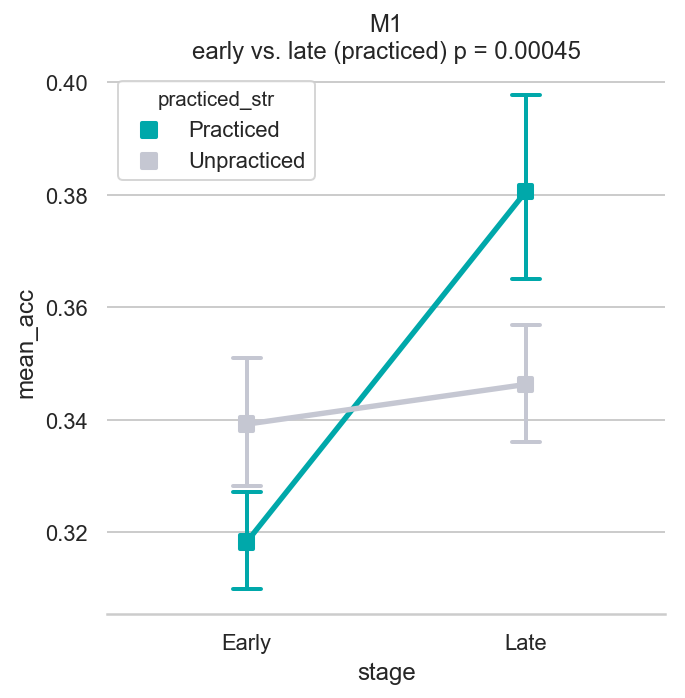

In [46]:
draw_lineplot('M1')

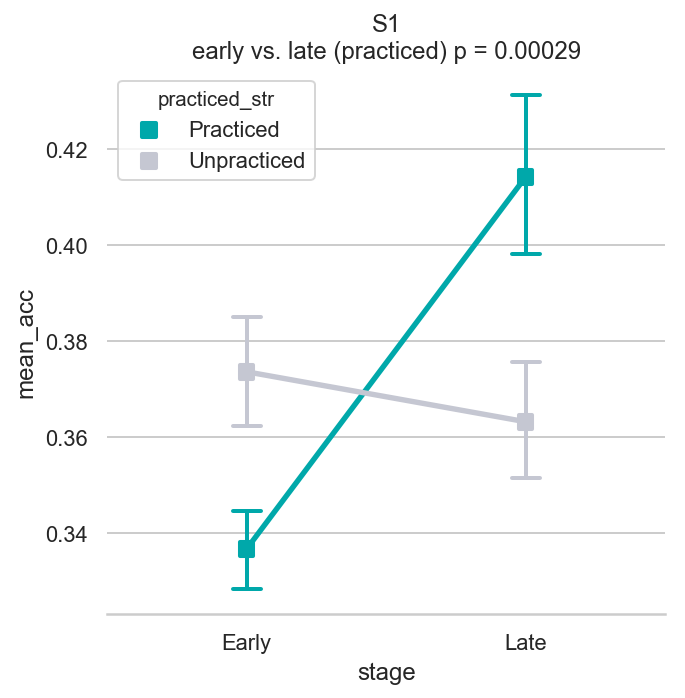

In [47]:
draw_lineplot('S1')

In [48]:
wit_df.to_csv('20200306_ROI-based-MVPA_m1-s1.csv')